In [1]:
import numpy as np

from qiskit import QuantumCircuit, Aer, IBMQ, ClassicalRegister
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile, assemble

from variational_tfd import QAOA_TFD

# Preparing TFD on Quantum Computers

Our goal is to run the teleportation protocol at finite temperature. To do this, we need to prepare the thermofield double; however, this is not trivial with current hardware. Here, we try to understand what is the best setup to prepare the TFD. 

To prepare the thermofield double we use the technique of [Wu, Hsieh 2018](https://arxiv.org/abs/1811.11756). We are satisfied in finding the optimal angles with a classical simulation, which we run in `preparing_tfd`. 

We have a few choices to make:
1. Model:
- Transverse field Ising model (TFID), see [Zhu et al 2019](https://arxiv.org/pdf/1906.02699.pdf) or [Green et al. 2021](https://arxiv.org/abs/2112.02068); 
- Self-dual kicked Ising model, see [Shapoval et al. 2022](https://arxiv.org/abs/2205.14081);
2. Quantum computer:
- IBM;
- IonQ;
- Quantinuum;
3. Quantum compilation: we can start looking into [Shapoval et al. 2022](https://arxiv.org/abs/2205.14081) and into *tket*;
3. Error mitigation: we can start looking into [Shapoval et al. 2022](https://arxiv.org/abs/2205.14081) and the code they provide.

A tentative plan:
1. Prepare TFD for the different models on IBM machines, without optimization on compilation, or error mitigation. Here we don't need to learn anything new);
2. Start looking at optimization on compilation, or error mitigation on IBM machines. Probably a lot is already provided in *Qiskit*. In the meantime try to run the circuits from 1. on other machines;
3. If necessary extend compilation optimization and error mitigation to the new machines;
4. Pick the best setup.

## 0. Retrieving completed jobs

As running on real quantum hardware often takes a lot of time, it would be nice to have a way to access old jobs. This can be done as [follows](https://quantumcomputing.stackexchange.com/questions/23637/how-can-i-retrieve-qiskit-runtime-jobs-that-i-have-submitted-to-ibm-quantum). 

In [ ]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='HUB_NAME', group='GROUP_NAME', project='PROJECT_NAME')
job = provider.runtime.job('JOB_ID')

## 1. Running on IBM machines

In [2]:
# To run the simulations we need the following backend
backend_sim = Aer.get_backend('qasm_simulator')
# To run circuit on the quantum computer we use the following backend
my_token_shira = '0bb8d57a4ce7a0f492bfb515c7cab810ff15e014e6cb71263ebc6a8d74809f21f2cf1fe4a9a30ef18e0835a9bb711407da5b799f5fe391d0258f950d610f2783'
IBMQ.save_account(my_token_shira,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='ben-gurion-uni-1', project='main')
good_devices = provider.backends(filters=lambda device: device.name() in ['ibm_perth']) 
backend_exp = least_busy(good_devices)

Before considering any of the models above, we try to prepare the infinite temperature TFD, i.e. a bunch of Bell pairs. This will give us an idea of how well (or more likely how *bad*), the IBM machines perform. 

We consider a system of 6 qubits. We entangle the first qubit with the last, the second with the second last, and so on.

In [26]:
# create a circuit with 6 qubits
n = 3
circ_bell = QuantumCircuit(2*n, 2*n)
for i in range(n):
    # to entangle the qubits we first apply Hadamard (H) to one of them
    circ_bell.h(i)
    # and then apply CX to the other, controlled on the qubit on which we have applied H
    circ_bell.cx(i, 2*n-1-i)
circ_bell.barrier(range(2*n))
circ_bell.measure(range(2*n), range(2*n))

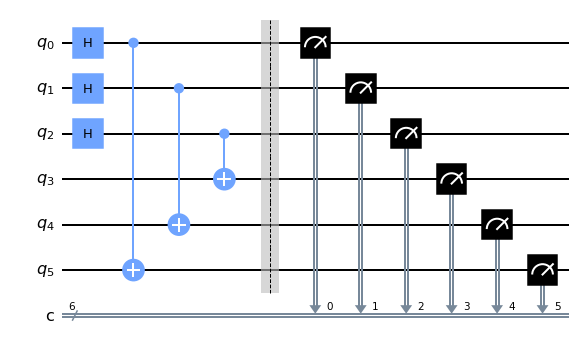

In [27]:
circ_bell.draw('mpl')

First, we simulate the system without noise, using the `qasm_simulator` from `AER`.

In [28]:
job_bell_sim = backend_sim.run(transpile(circ_bell, backend_sim), shots=1024)
result_bell_sim = job_bell_sim.result()

/Users/af_rotundo/miniforge3/envs/qg_lab/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/af_rotundo/miniforge3/envs/qg_lab/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [29]:
print(result_bell_sim.get_counts())

{'111111': 123, '101101': 138, '001100': 101, '010010': 122, '100001': 138, '011110': 121, '110011': 147, '000000': 134}


Next, we run the circuit on a quantum computer, and compare the result. 

In [30]:
job_bell_exp = backend_exp.run(transpile(circ_bell, backend_exp), shots=1024)
job_bell_exp.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [31]:
result_bell_exp = job_bell_exp.result()
print(result_bell_exp.get_counts())

ibmqjob._wait_for_completion:ERROR:2022-07-27 21:09:49,736: Maximum retries exceeded: Error checking job status due to a network error.


IBMQJobApiError: 'Error checking job status due to a network error: "HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-research-2/Groups/ben-gurion-uni-1/Projects/main/Jobs/62e16175c2d4974a8fe36dae/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x28507ac50>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'

**TO DO:** 
1. what's a reasonable way to measure the distance between the simulation and the experiment?
2. what other measurements should we do to probe the phases?

#### Transverse Field Ising Model (TFIM)

We can build the circuit using `QAOA_TFD` from `variational_tfd`. To begin with, we consider one layer $d=1$. The angles were found in `preparing_TFD`. Finally we need to pick a temperature. Let's first consider infinite temperature $\beta=0$. 

**TO DO:** later, we want to consider finite temperatures. To understand what's a reasonable value for finite temperature, it would be good to understand what's the distance between the ground state and both the first excited state and the highest energy state. 

In [16]:
d = 1
theta = 4*d*[0]
qaoa_tfim = QAOA_TFD(n, d, theta)
# we need to add measurements to the circuit 
qaoa_tfim.circuit.add_register(ClassicalRegister(6,'creg'))
qaoa_tfim.circuit.measure(range(6), range(6))

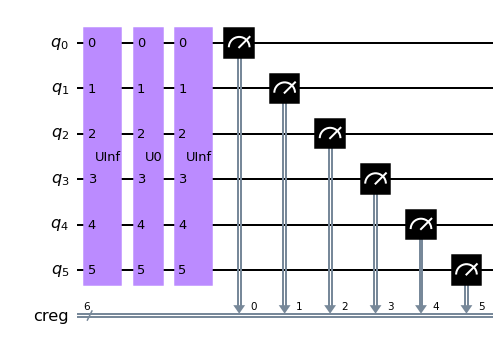

In [17]:
qaoa_tfim.circuit.draw('mpl')

Let's simulate the circuit.

In [20]:
job_tfim0_sim = backend_sim.run(transpile(qaoa_tfim.circuit, backend_sim), shots=1024)
result_tfim0_sim = job_tfim0_sim.result()

In [21]:
print(result_tfim0_sim.get_counts())

{'000000': 116, '111111': 127, '001001': 152, '011011': 131, '101101': 145, '100100': 122, '010010': 115, '110110': 116}


In [22]:
job_tfim0_exp = backend_exp.run(transpile(qaoa_tfim.circuit, backend_exp), shots=1024)
job_tfim0_exp.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [25]:
result_tfim0_exp = job_tfim0_exp.result()
print(result_tfim0_exp.get_counts())

{'000000': 42, '000001': 54, '010000': 21, '010001': 9, '010010': 62, '010011': 25, '010100': 7, '010101': 1, '010110': 8, '010111': 6, '011000': 8, '011001': 5, '011010': 16, '011011': 52, '011100': 2, '011101': 7, '011110': 2, '011111': 9, '000010': 13, '100000': 21, '100001': 17, '100010': 7, '100011': 5, '100100': 59, '100101': 10, '100110': 10, '100111': 10, '101000': 9, '101001': 20, '101010': 4, '101011': 4, '101100': 20, '101101': 46, '101110': 8, '101111': 10, '000011': 9, '110000': 7, '110001': 5, '110010': 17, '110011': 13, '110100': 18, '110101': 9, '110110': 32, '110111': 30, '111000': 4, '111001': 2, '111010': 13, '111011': 11, '111100': 7, '111101': 9, '111110': 27, '111111': 19, '000100': 10, '000101': 1, '000110': 5, '000111': 4, '001000': 71, '001001': 39, '001010': 7, '001011': 15, '001100': 4, '001101': 14, '001110': 7, '001111': 6}


## Check infinite temperature state preparation

In `QAOA_TFD` we first of all prepare the infinite temperature TFD. Let's check this step alone.

In [3]:
# create a circuit with 6 qubits
n = 3
circ_tfd0 = QuantumCircuit(2*n, 2*n)
for i in range(n):
    circ_tfd0.rxx(np.pi/2, i, i+n)
        # we add the R_Z gates
for i in range(n):
    circ_tfd0.rz(np.pi/4, i)
    circ_tfd0.rz(np.pi/4, i+n)
circ_tfd0.barrier(range(2*n))
circ_tfd0.measure(range(2*n), range(2*n))

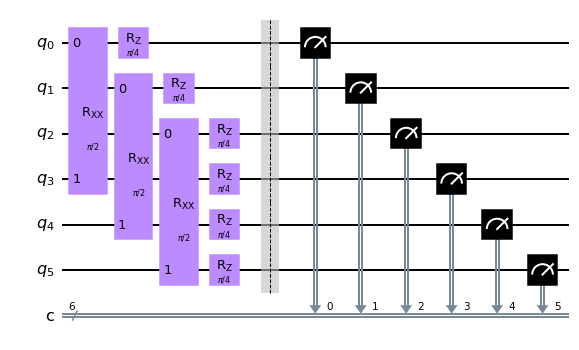

In [4]:
circ_tfd0.draw('mpl')

In [5]:
job_tfd0_sim = backend_sim.run(transpile(circ_tfd0, backend_sim), shots=1024)
result_tfd0_sim = job_tfd0_sim.result()

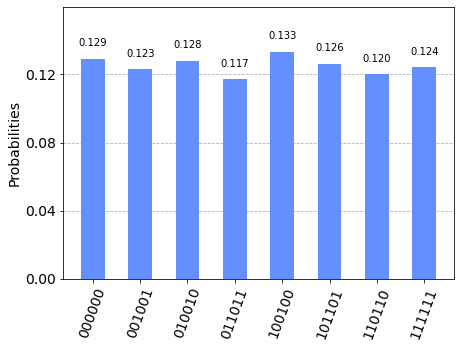

In [6]:
result_tfd0_sim = job_tfd0_sim.result()
plot_histogram(result_tfd0_sim.get_counts())

In [7]:
job_tfd0_exp = backend_exp.run(transpile(circ_tfd0, backend_exp), shots=1024)
job_tfd0_exp.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [9]:
result_tfd0_exp = job_tfd0_exp.result()
plot_histogram(result_tfd0_exp.get_counts()[:10])

TypeError: unhashable type: 'slice'

In [25]:
result_bell_exp_counts = {'000000': 167, '000001': 15, '010000': 14, '010001': 1, '010010': 63, '010011': 13, '010100': 1, '010101': 2, '010110': 3, '010111': 1, '011000': 3, '011001': 2, '011010': 4, '011011': 2, '011100': 4, '011101': 3, '011110': 48, '011111': 9, '000010': 2, '100000': 48, '100001': 77, '100010': 6, '100011': 5, '100100': 4, '100101': 2, '101000': 5, '101001': 4, '101011': 1, '101100': 27, '101101': 48, '101110': 3, '101111': 12, '000011': 2, '110000': 6, '110001': 18, '110010': 39, '110011': 81, '110100': 2, '110101': 1, '110110': 3, '110111': 4, '111000': 6, '111010': 4, '111011': 8, '111100': 6, '111101': 8, '111110': 29, '111111': 42, '000100': 7, '000101': 1, '000110': 2, '001000': 11, '001001': 3, '001010': 1, '001011': 1, '001100': 121, '001101': 14, '001110': 2, '001111': 3}
{key: result_bell_exp_counts[key] for key in result_tfd0_sim.get_counts().keys()}

{'111111': 42,
 '001001': 3,
 '101101': 48,
 '110110': 3,
 '010010': 63,
 '100100': 4,
 '011011': 2,
 '000000': 167}

In [15]:
{key: result_tfd0_exp.get_counts()[key] for key in result_tfd0_sim.get_counts().keys()}

{'111111': 60,
 '001001': 78,
 '101101': 88,
 '110110': 46,
 '010010': 47,
 '100100': 72,
 '011011': 60,
 '000000': 61}

In [22]:
{x: result_tfd0_exp.get_counts()[x] for x in result_tfd0_exp.get_counts().keys() if result_tfd0_exp.get_counts()[x] > 40}

{'000000': 61,
 '010010': 47,
 '011011': 60,
 '011111': 45,
 '100100': 72,
 '101101': 88,
 '110110': 46,
 '111111': 60,
 '001001': 78}

In [21]:
result_tfd0_sim.get_counts()

{'111111': 127,
 '001001': 126,
 '101101': 129,
 '110110': 123,
 '010010': 131,
 '100100': 136,
 '011011': 120,
 '000000': 132}

In [ ]:
(x0, x1) for x0 in --- for x1 in ---